In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

datasets = ["Caltech256","SUN397","iWildCam","iWildCamOOD","CIFAR10","CINIC10"]
nbn = "02_" # Notebook Number; Prefix for artifacts path

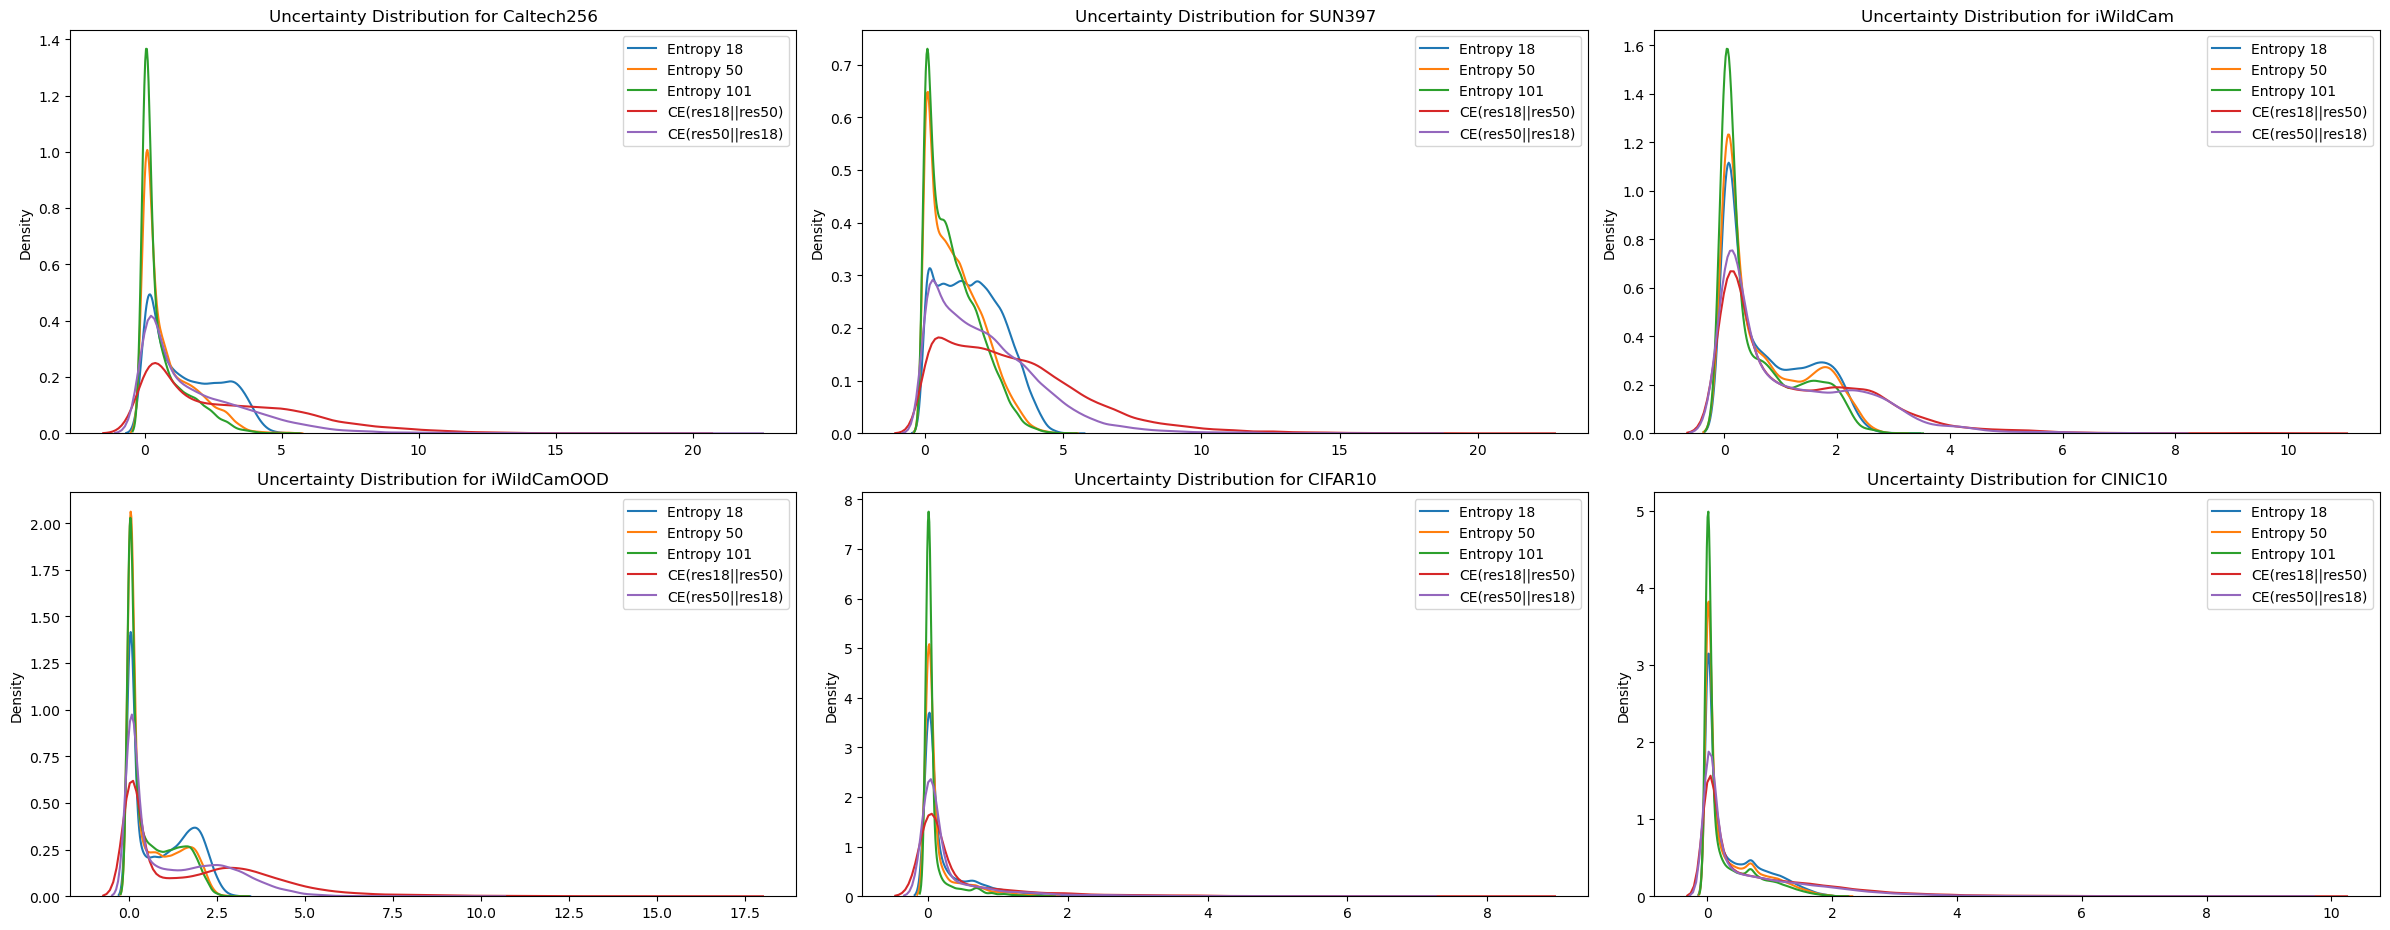

In [61]:
nrows = 3
ncols = 3

pred_prefix = "csv/prediction_"
pred_suffix = "_Resnet"
unc_prefix = "csv/uncertainty_"

fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 5 * nrows))

for i, ds in enumerate(datasets):
    pred = pd.read_csv(f"{pred_prefix}{ds}{pred_suffix}.csv", index_col="Unnamed: 0")
    unc_pred = pd.read_csv(f"{unc_prefix}{ds}{pred_suffix}.csv", index_col="Unnamed: 0")
    ax = axes[i // ncols, i % ncols]

    sns.kdeplot(unc_pred["ent_18"], label='Entropy 18', ax=ax)
    sns.kdeplot(unc_pred["ent_50"], label='Entropy 50', ax=ax)
    sns.kdeplot(unc_pred["ent_101"], label='Entropy 101', ax=ax)
    # sns.kdeplot(unc_pred["ce_18_101"], label='CE(res18||res101)', ax=ax)
    # sns.kdeplot(unc_pred["ce_101_18"], label='CE(res101||res18)', ax=ax)
    sns.kdeplot(unc_pred["ce_18_50"], label='CE(res18||res50)', ax=ax)
    sns.kdeplot(unc_pred["ce_50_18"], label='CE(res50||res18)', ax=ax)

    ax.set_title(f'Uncertainty Distribution for {ds}')
    ax.set_xlabel("")
    ax.set_ylabel('Density')
    ax.legend()


for j in range(len(datasets), nrows * ncols):
    fig.delaxes(axes[j // ncols, j % ncols])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig(f"artifacts/{nbn}uncertainty_distributions.png")

plt.show()

In [62]:
# fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 5 * nrows))

# for i, ds in enumerate(datasets):
#     pred = pd.read_csv(f"{pred_prefix}{ds}{pred_suffix}.csv", index_col="Unnamed: 0")
#     unc_pred = pd.read_csv(f"{unc_prefix}{ds}{pred_suffix}.csv", index_col="Unnamed: 0")
#     ax = axes[i // ncols, i % ncols]

#     sns.kdeplot(unc_pred["nll_18"], label='NLL 18', ax=ax)
#     sns.kdeplot(unc_pred["nll_101"], label='NLL 101', ax=ax)
#     sns.kdeplot(unc_pred["brier_18"], label='Brier 18', ax=ax)
#     sns.kdeplot(unc_pred["brier_101"], label='Brier 101', ax=ax)

#     ax.set_title(f'Uncertainty Distribution for {ds}')
#     ax.set_xlabel("")
#     ax.set_ylabel('Density')
#     ax.legend()


# for j in range(len(datasets), nrows * ncols):
#     fig.delaxes(axes[j // ncols, j % ncols])

# plt.savefig(f"artifacts/{nbn}nll_brier_distributions.png")

# plt.show()

In [63]:
pred = pd.read_csv(f"{pred_prefix}{ds}{pred_suffix}.csv", index_col="Unnamed: 0")
display(pred.head(1))
unc_pred = pd.read_csv(f"{unc_prefix}{ds}{pred_suffix}.csv", index_col="Unnamed: 0")
display(unc_pred.head(1))


,pred18,pred50,pred101,target,soft_vote_logits,soft_vote_softmax,min_entropy_pred
0,0,0,0,0,0,0,0


,ent_18,ent_50,ent_101,ce_18_50,ce_50_18,ent_18_np,ent_50_np,ent_101_np,ce_18_50_np,ce_50_18_np,nll_18,nll_50,nll_101,brier_18,brier_50,brier_101,softmax_response18,softmax_response50,softmax_response101
0,0.029562,0.073289,0.028359,0.034032,0.080852,0.030332,0.074025,0.029212,0.034695,0.081442,0.003595,0.010592,0.003734,134.90522,274.592906,320.712957,0.996412,0.989464,0.996273


In [64]:
from scipy import stats
for ds in datasets:
    print(f"For {ds}:")
    pred = pd.read_csv(f"{pred_prefix}{ds}{pred_suffix}.csv", index_col="Unnamed: 0")
    unc_pred = pd.read_csv(f"{unc_prefix}{ds}{pred_suffix}.csv", index_col="Unnamed: 0")
    spearman_entS_entM = stats.spearmanr(unc_pred["ent_18"], unc_pred["ent_50"]).statistic
    spearman_entS_entL = stats.spearmanr(unc_pred["ent_18"], unc_pred["ent_101"]).statistic
    spearman_entM_entL = stats.spearmanr(unc_pred["ent_50"], unc_pred["ent_101"]).statistic
    spearman_entM_ce_M_S = stats.spearmanr(unc_pred["ent_50"], unc_pred["ce_50_18"]).statistic
    spearman_ce_M_S_ce_M_S = stats.spearmanr(unc_pred["ce_50_18_np"], unc_pred["ce_50_18"]).statistic
    spearman_entM_entM_plus_ce_M_S_plus_ce_S_M = stats.spearmanr(unc_pred["ent_50"], unc_pred["ent_50"]+(unc_pred["ce_50_18"]+unc_pred["ce_18_50"])).statistic
    spearman_entM_entM_times_ce_M_S = stats.spearmanr(unc_pred["ent_50"], unc_pred["ent_50"]*unc_pred["ce_50_18"]).statistic
    print(f"spearman between entr S and entr M: {spearman_entS_entM:.3f}")
    print(f"spearman between entr S and entr L: {spearman_entS_entL:.3f}")
    print(f"spearman between entr M and entr L: {spearman_entM_entL:.3f}")
    print(f"spearman between entr M and cross-entr(M||S): {spearman_entM_ce_M_S:.3f}")
    print(f"spearman between cross-entr(M||S)[scipy] and cross-entr(M||S)[torch]: {spearman_ce_M_S_ce_M_S:.3f}")

For Caltech256:
spearman between entr S and entr M: 0.499
spearman between entr S and entr L: 0.490
spearman between entr M and entr L: 0.561
spearman between entr M and cross-entr(M||S): 0.844
spearman between cross-entr(M||S)[scipy] and cross-entr(M||S)[torch]: 1.000
For SUN397:
spearman between entr S and entr M: 0.510
spearman between entr S and entr L: 0.502
spearman between entr M and entr L: 0.585
spearman between entr M and cross-entr(M||S): 0.841
spearman between cross-entr(M||S)[scipy] and cross-entr(M||S)[torch]: 1.000
For iWildCam:
spearman between entr S and entr M: 0.788
spearman between entr S and entr L: 0.766
spearman between entr M and entr L: 0.832
spearman between entr M and cross-entr(M||S): 0.952
spearman between cross-entr(M||S)[scipy] and cross-entr(M||S)[torch]: 1.000
For iWildCamOOD:
spearman between entr S and entr M: 0.716
spearman between entr S and entr L: 0.779
spearman between entr M and entr L: 0.822
spearman between entr M and cross-entr(M||S): 0.901
s